In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import math
import cv2
import torch

In [24]:
N  = 100
channels = 6

# optical parameter
lambdad = 532e-9
pitch = 400e-9
d = 40e-6
L = N * pitch
k0 = 2*np.pi / lambdad

# generalized snells' law
anglepara = 0.33
theta = np.linspace(-np.pi*anglepara,np.pi*anglepara,channels) # 折射角度
dphi = pitch * np.sin(theta) * k0 # 相位梯度

# the target phase distribution
x = np.linspace(-1/2*L,1/2*L,N)
y = np.linspace(-1/2*L,1/2*L,N)
phase =  np.zeros([channels,N]) # N*M
for i in range(channels):
    phase[i,:] = x / pitch * dphi[i]%(2*np.pi)

# least square method
AT = np.array([np.cos(theta)**2,np.sin(2*theta),np.sin(theta)**2])
A =  np.transpose(AT)
a1 = np.linalg.inv(np.dot(AT,A))
AI = np.dot(a1,AT)
E = np.dot(AI,np.exp(1j*phase))
O=np.dot(A,E)

# engineered noize
#plt.plot(np.transpose(phase))
sigma = 0.7
Noise = np.dot(A,sigma*np.random.randn(3,N))
#O = O + Noise
err=np.abs(O-np.exp(1j*phase))

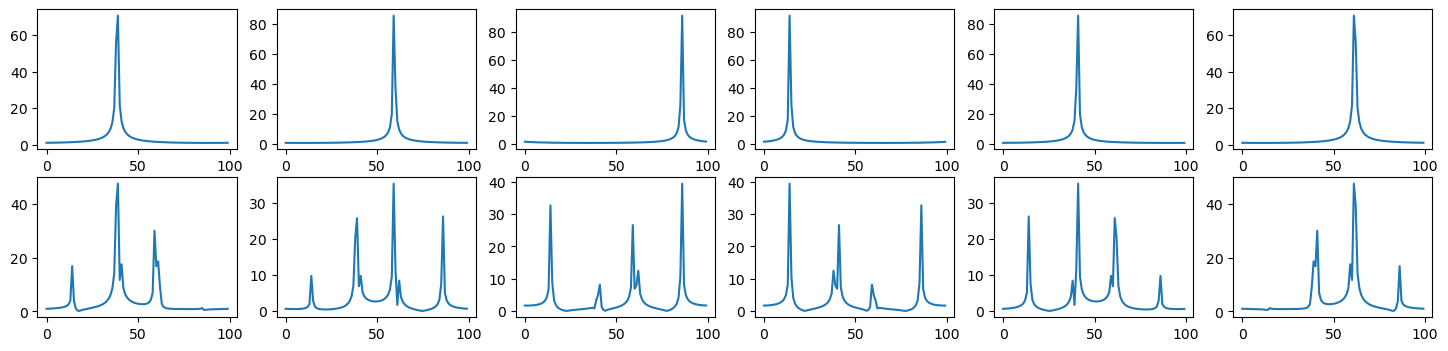

In [25]:
fig, axs = plt.subplots( 2,channels,figsize=(18,4))
images = []
for i in range (channels):
    images.append(axs[0][i].plot(np.abs(np.fft.fft(np.exp(1j*phase[i,:])))))
    images.append(axs[1][i].plot(np.abs(np.fft.fft(O[i,:]))))
plt.show()

In [26]:
DNA_SIZE = N                 # DNA (real number)
DNA_BOUND = [-np.pi, np.pi]       # solution upper and lower bounds
N_GENERATIONS = 5000
MUT_STRENGTH = 1.            # initial step size (dynamic mutation strength)

FTideal = np.zeros_like(phase)
FT_ = np.zeros_like(phase,dtype=complex)
for i in range(channels):   # calculate ideal farfield
    FT_[i,:] = np.fft.fft(np.exp(1j*phase[i,:]))
FTideal = np.abs(FT_ * np.conj(FT_))
phase.shape

(6, 100)

In [27]:

def MSE(pred,target):
    return (np.sum((target - pred) ** 2)/len(target))
def RMSE(pred,target):
    return np.sqrt(np.sum((target - pred) ** 2)/len(target))

def propagation(dE):
    nearfield = np.dot(A,dE) + O
    farfield = np.zeros_like(nearfield)
    for i in range(channels):
        farfield[i,:] = np.fft.fft(nearfield[i,:])
        I = np.abs(farfield*np.conj(farfield))
    return I

def loss(FT):
    return -RMSE(FT,FTideal)

def make_kid(parent):
    # no crossover, only mutation
    k = parent + MUT_STRENGTH * np.random.randn(3,DNA_SIZE)
    k = np.clip(k, *DNA_BOUND)
    return k

def kill_bad(parent, kid):
    global MUT_STRENGTH
    fp = loss(propagation(parent))
    fk = loss(propagation(kid))
    p_target = 1/5
    if fp < fk:     # kid better than parent
        parent = kid
        ps = 1.     # kid win -> ps = 1 (successful offspring)
    else:
        ps = 0.
    # adjust global mutation strength
    MUT_STRENGTH *= np.exp(1/np.sqrt(DNA_SIZE+1) * (ps - p_target)/(1 - p_target))
    return parent

-5744.104128722333


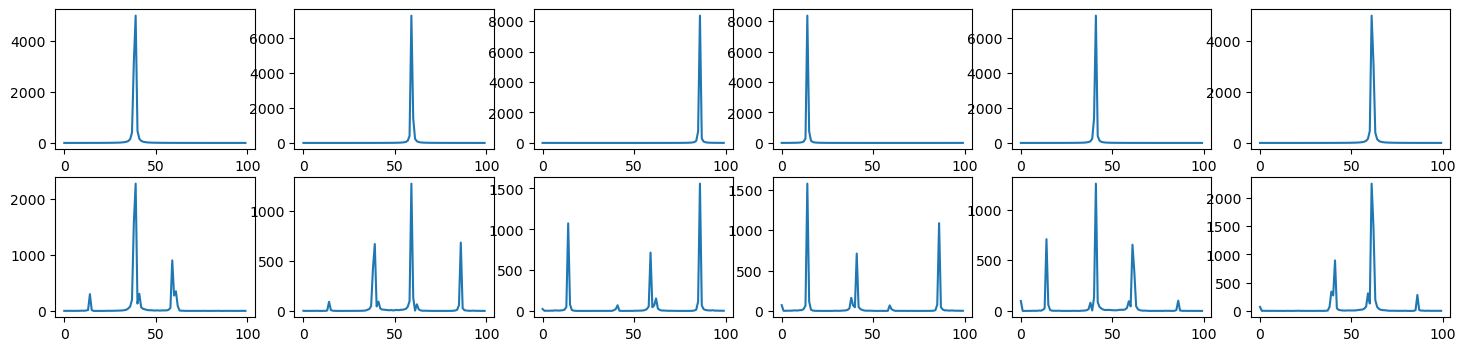

In [28]:
parent = 0.1*np.random.rand(3,DNA_SIZE)
print(loss(propagation(parent)))
a = propagation(parent)
fig, axs = plt.subplots( 2,channels,figsize=(18,4))
images = []
for i in range (channels):
    images.append(axs[0][i].plot(FTideal[i,:]))
    images.append(axs[1][i].plot(a[i,:]))
plt.show()

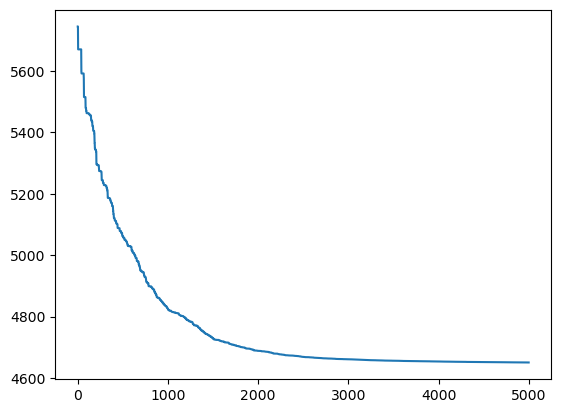

0.006099395568604669


In [29]:

plt.ion()       # something about plotting
x = range(0,N_GENERATIONS)
lossrec = np.zeros_like(x,dtype = float)

for i in range(N_GENERATIONS):
    # ES part
    kid = make_kid(parent)
    parent = kill_bad(parent, kid)
    lossrec[i] = -loss(propagation(parent))
plt.plot(x,lossrec)
plt.show()
print(MUT_STRENGTH)

-4650.884202761716


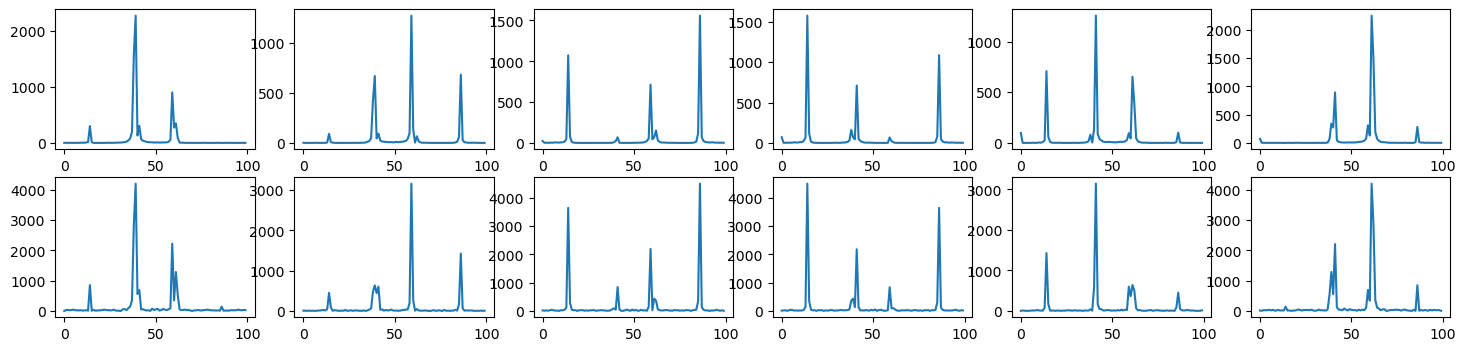

In [30]:
print(loss(propagation(parent)))
fig, axs = plt.subplots( 2,channels,figsize=(18,4))
images = []
for i in range (channels):
    images.append(axs[0][i].plot(a[i,:]))
    images.append(axs[1][i].plot(propagation(parent)[i,:]))
plt.show()

In [31]:
# 角谱法
def AS_Propagation(Uin,z,lambdad,L):
    
    nx = Uin.shape[0]
    ny = Uin.shape[1]
    x = np.linspace(-nx//2,nx//2-1,nx)
    y = np.linspace(-ny//2,ny//2-1,ny)
    X,Y=np.meshgrid(x,y)
    fx = X/L
    fy = Y/L
    k = 2*np.pi/lambdad
    q = fx**2 + fy**2
    H = np.exp(1.0j*k*z*np.sqrt(1-(lambdad**2)*q))
    O = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(Uin)))
    U = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(H*O)))
    
    return U


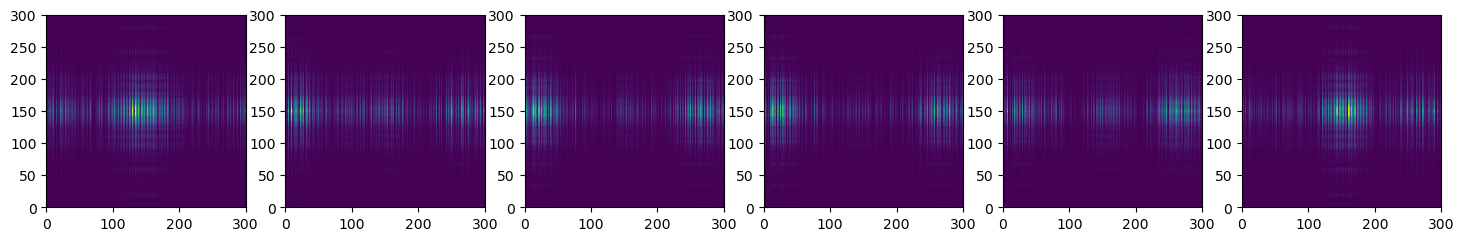

In [32]:
padnum = 100

jet = cm.get_cmap('jet')
fig, axs = plt.subplots(1,channels,figsize=(18,2.5))
images = []
for i in range (channels):
    O_ = O+np.dot(A,parent)
    Oin = O_[i,:].reshape(1,N)
    Oin = np.repeat(Oin,N,axis = 0)
    Oin = np.pad(Oin,[(padnum,padnum),(padnum,padnum)],'constant')
    out = AS_Propagation(Oin,1e-3,lambdad,Oin.shape[0]*pitch)
    I = np.abs(out*np.conj(out))
    images.append(axs[i].pcolormesh(I))
plt.show()


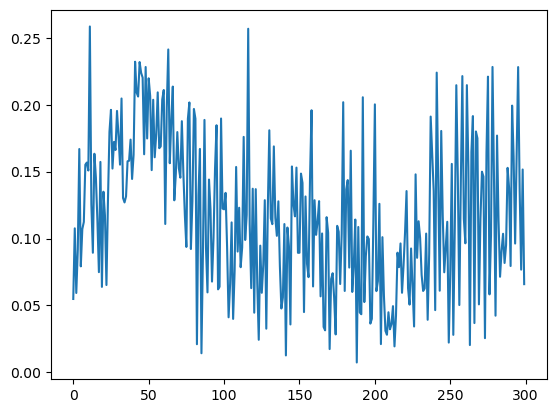

In [183]:
plt.plot(np.abs(out[50,:]))